# Intro

In this example, we will use `braingraphgeo` to construct random geometric surrogate graphs that can be used to benchmark network properties. 

We start by importing some base packages:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from braingraphgeo.utils import load_connectivity_matrix
%matplotlib inline

np.seterr(divide='ignore');  # catch divide-by-zero warnings

# Motivation

The motivation for these geometric surrogate graphs is that the network properties of the brain are partially determined by its spatial embedding - gray matter regions that are closer together are more likely to be strongly connected than those that are far apart. 

We can visualize that directly using our example data and distance matrix. First let's load all of our data:

In [2]:
def load_mean_tract_graph(path):
    '''Utility function to load and average tractography graphs'''
    tract_mats = []
    for i in range(1,6):
        mat = load_connectivity_matrix(path + f'_n{i}.csv').values
        tract_mats.append(mat)
    tract = np.mean(tract_mats,0)
    return tract

In [3]:
distance = load_connectivity_matrix('../data/fiber_distances.csv').values
tracer = load_connectivity_matrix('../data/tracer.csv').values
dense_tract = load_mean_tract_graph('../data/tract_dense')
endpoint_tract = load_mean_tract_graph('../data/tract_endpoint')

Now let's make a plot to show the falloff of connectivity weight with distance for the tracer graph and the two tractography graphs. 

In the "Visualize and compare connectivity weights" example, we saw that the connectivity weights follow differerent distributions for each method. So we normalize the weights with a z-score and average them within distance bins:

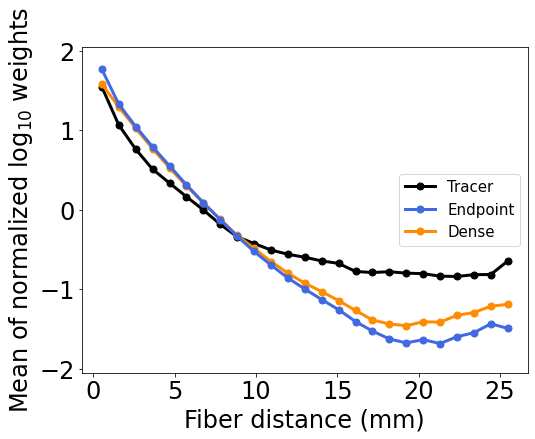

In [5]:
def zscore(a):
    '''Utility function to calculate the z-score of an array'''
    return (a - np.nanmean(a)) / np.nanstd(a)

# Style selections
matplotlib.rc('font', **{'size': 24})
matplotlib.rc('lines', linewidth=3, markersize=7)
colors = {'endpoint': 'royalblue', 'dense': 'darkorange'}

# Number of unique weights since second hemisphere is redundant
N = distance.shape[0] // 2

# We group the distances into bins to show overall trend
bins = 25
D = distance[:N].flatten()
Dmask = ~np.isnan(D)  # removing any missing distances
dbins = np.linspace(0, 26, bins+1)  # define bins
dlabs = (dbins + np.diff(dbins)[0] / 2)[:-1]  # label as center value
dbinned = pd.cut(D[Dmask], bins=dbins, labels=dlabs)  # bin distances

# Clean tracer data and create DataFrame linking distance
# bin and z-score
tracer_fig = np.log10(tracer)[:286].flatten()[Dmask]
tracer_fig[np.isinf(tracer_fig)] = np.nan
tracer_df = pd.DataFrame({'D' : dbinned, 'w' : zscore(tracer_fig)})

# Clean tract data and create DataFrame linking distance
# bin and z-score for both dense and endpoint
tract_dfs = {}
for conn, tract in zip(['dense', 'endpoint'],[dense_tract, endpoint_tract]):
    tract_dfs[f'{conn}'] = pd.DataFrame(dbinned,columns=['D'])
    
    tract_fig = np.log10(tract)[:286].flatten()[Dmask]
    tract_fig[np.isinf(tract_fig)] = np.nan
    tract_dfs[f'{conn}'][f'w'] = zscore(tract_fig)

# Plot mean weight z-score for each distance bin
fig, ax = plt.subplots(figsize=(8, 6))

# Tracer
tracer_meandf = tracer_df.groupby('D').mean()
ax.plot(np.array(tracer_meandf.index),
        tracer_meandf['w'],
        marker='o',
        color='k')

# Tractography
for conn in ['dense', 'endpoint']:
    tract_meandf = tract_dfs[conn].groupby('D').mean()
    ax.plot(np.array(tract_meandf.index),
            tract_meandf['w'],
            marker='o',
            color=colors[conn])
    
ax.set_ylim([-2.05, 2.05])
ax.set_xlabel('Fiber distance (mm)')
ax.set_ylabel(r'Mean of normalized log$_{10}$ weights')

handles = [Line2D([0], [0], marker='o', color='k', ls='-', label='Tracer'),
           Line2D([0], [0], marker='o', color=colors['endpoint'],ls='-', label='Endpoint'),
           Line2D([0], [0], marker='o', color=colors['dense'],ls='-', label='Dense')]
ax.legend(handles=handles, loc='center right', fontsize=15);

We see that both tractography methods dramatically underestimate connectivity at long-distances compared to tracers. 

This provides evidence of geometric bias in network construction with tractography. Comparing the "empirical" graphs to random geometric surrogates is a powerful tool to explore how this bias effects other network properties.

# Constructing geometric surrogates

The idea is to use an empirical graph to construct a surrogate graph such that:
1. The original strength distribution is preserved
2. The original low-order weight-distance relationships are preserved

but the graph is otherwise random.

`braingraphgeo` provides tools for constructing these graphs in the `surrogates` module:

In [6]:
from braingraphgeo.surrogates import geomsurr

Wgeo = geomsurr(tracer, distance)

Let's visualize and compare the two graphs. 

First, the original tracer graph:

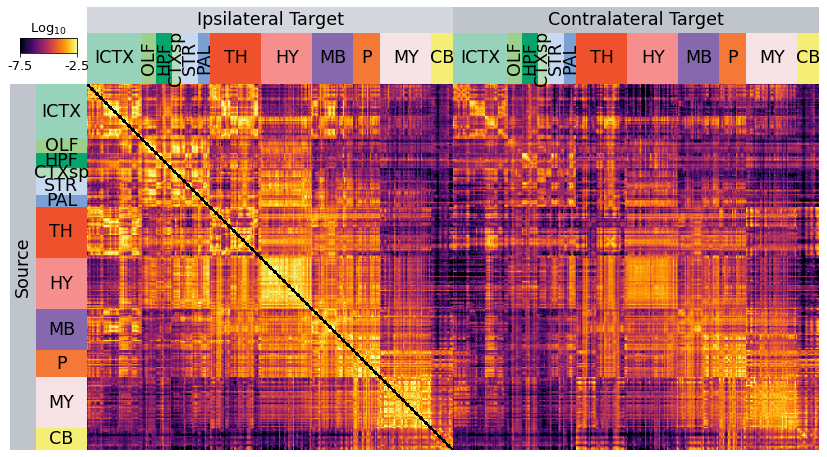

In [7]:
from braingraphgeo.vis import connectivity_matrix

tracer_vis = tracer[:N]

# Load parcellation data
parcellation = pd.read_csv('../data/parcellation.csv')

fig, ax = connectivity_matrix(np.log10(tracer_vis),parcellation,vmin=-7.5,vmax=-2.5)

Now the geometric surrogate:

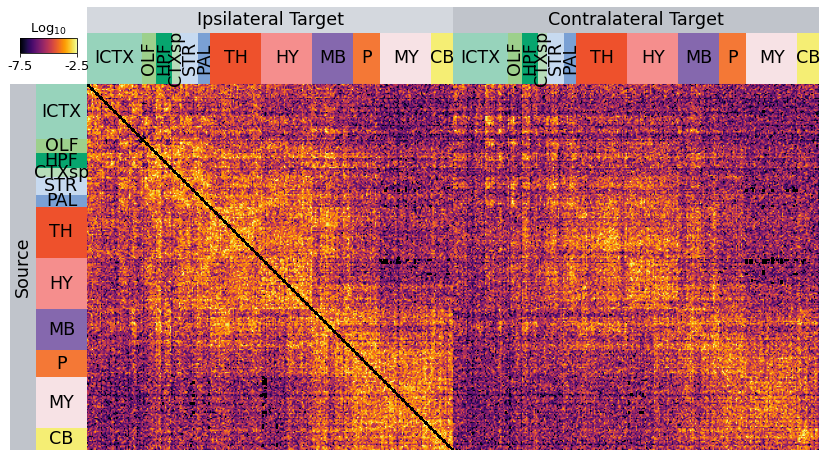

In [8]:
Wgeo_vis = Wgeo[:N]
fig, ax = connectivity_matrix(np.log10(Wgeo_vis),parcellation,vmin=-7.5,vmax=-2.5)

While the surrogate graph is definitely noisier (as expected), we still see similar structure appear in certain areas, indicating that some component of mouse brain structure is determined geometrically. 

Let's see if our two conditions from early were held:

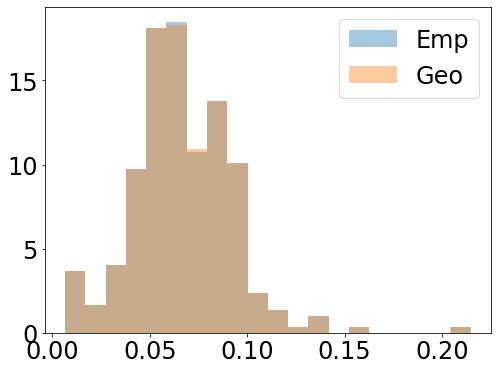

In [18]:
fig, ax = plt.subplots(figsize=(8,6))

strength_emp = tracer.sum(0)
strength_geo = Wgeo.sum(0)

bins=20
ax.hist(strength_emp,bins,alpha=0.4,density=True,label='Emp')
ax.hist(strength_geo,bins,alpha=0.4,density=True,label='Geo')
ax.legend();

The two strength distributions line up nicely.

Now for the strength-distance relationships (recycling some code from earlier):

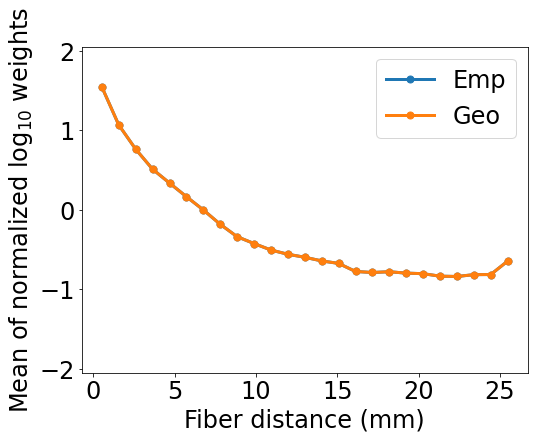

In [21]:
geo_fig = np.log10(Wgeo)[:286].flatten()[Dmask]
geo_fig[np.isinf(geo_fig)] = np.nan
geo_df = pd.DataFrame({'D' : dbinned, 'w' : zscore(geo_fig)})
geo_meandf = geo_df.groupby('D').mean()

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(np.array(tracer_meandf.index),
        tracer_meandf['w'],
        marker='o',label='Emp')
ax.plot(np.array(geo_meandf.index),
        tracer_meandf['w'],
        marker='o',label='Geo')
ax.legend()
ax.set_ylim([-2.05, 2.05])
ax.set_xlabel('Fiber distance (mm)')
ax.set_ylabel(r'Mean of normalized log$_{10}$ weights');

Our 